# Conformance Checking using pm4py
<hr>
Conformance checking is a technique to compare a process model with an event log of the same process. The goal is to check if the event log conforms to the model, and, vice versa.

Some methods used for conformance checking:
1. Token based replay
2. Alignments
3. Footprints


## 1. Token Based Replay

<hr>

- In token based replay tokens are used to replay a trace on a Petri Net model.
- Starting from the initial place we try to discover which transitions are executed.
- We maintain count of 4 tokens: 
        - p (produced tokens)
        - c (consumed tokens)
        - m (missing tokens)
        - r (remaining tokens)
    
- If an event occurs even though it was not possible according to the model, m is incremented.
- If an event does not occur, even though it was possible according to the log, r is incremented.

In PM4Py there is an implementation of a token replayer that is able to go across hidden transitions (calculating shortest paths between places) and can be used with any Petri net model with unique visible transitions and hidden transitions. 

When a visible transition needs to be fired and not all places in the preset are provided with the correct number of tokens, starting from the current marking it is checked if for some place there is a sequence of hidden transitions that could be fired in order to enable the visible transition. 

The hidden transitions are then fired and a marking that permits to enable the visible transition is reached.

The output, contains for each trace in the log:
- trace_is_fit: boolean value (True/False) that is true when the trace is according to the model.
- activated_transitions: list of transitions activated in the model by the token-based replay.
- reached_marking: marking reached at the end of the replay.
- missing_tokens: number of missing tokens.
- consumed_tokens: number of consumed tokens.
- remaining_tokens: number of remaining tokens.
- produced_tokens: number of produced tokens.

In [56]:
import pm4py
import os

In [58]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
path = os.path.join("running-example.xes")

log = xes_importer.apply(path)

net, initial_marking, final_marking = alpha_miner.apply(log)

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

In [59]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

In [60]:
print(replayed_traces[0])

{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [(register request, 'register request'), (examine casually, 'examine casually'), (check ticket, 'check ticket'), (decide, 'decide'), (reinitiate request, 'reinitiate request'), (examine thoroughly, 'examine thoroughly'), (check ticket, 'check ticket'), (decide, 'decide'), (pay compensation, 'pay compensation')], 'reached_marking': ['end:1'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [], 'missing_tokens': 0, 'consumed_tokens': 12, 'remaining_tokens': 0, 'produced_tokens': 12}


#### Diagnostics by TBR
The execution of token-based replay in PM4Py permits to obtain detailed information about transitions that did not execute correctly, or activities that are in the log and not in the model. 

In particular, executions that do not match the model are expected to take longer throughput time.

The diagnostics that are provided by PM4Py are the following:

- Throughput analysis on the transitions that are executed in an unfit way according to the process model (the Petri net).
- Throughput analysis on the activities that are not contained in the model.
- Root Cause Analysis on the causes that lead to an unfit execution of the transitions.
- Root Cause Analysis on the causes that lead to executing activities that are not contained in the process model.

In [64]:
path2 = os.path.join("receipt.xes")
log = xes_importer.apply(path2)

parsing log, completed traces ::   0%|          | 0/1434 [00:00<?, ?it/s]

In [65]:
#For creating an unfit model, we keep only part of the behavior, removing some by filering
from pm4py.algo.filtering.log.auto_filter.auto_filter import apply_auto_filter

filtered_log = apply_auto_filter(log)

C:\Users\AREFA\AppData\Local\Temp\ipykernel_30568\2338765374.py:4: DeprecatedWarning: apply_auto_filter is deprecated as of 2.2.11 and will be removed in 3.0.0. Removed
  filtered_log = apply_auto_filter(log)


In [66]:
#obtaining model
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
net, initial_marking, final_marking =  inductive_miner.apply(filtered_log)

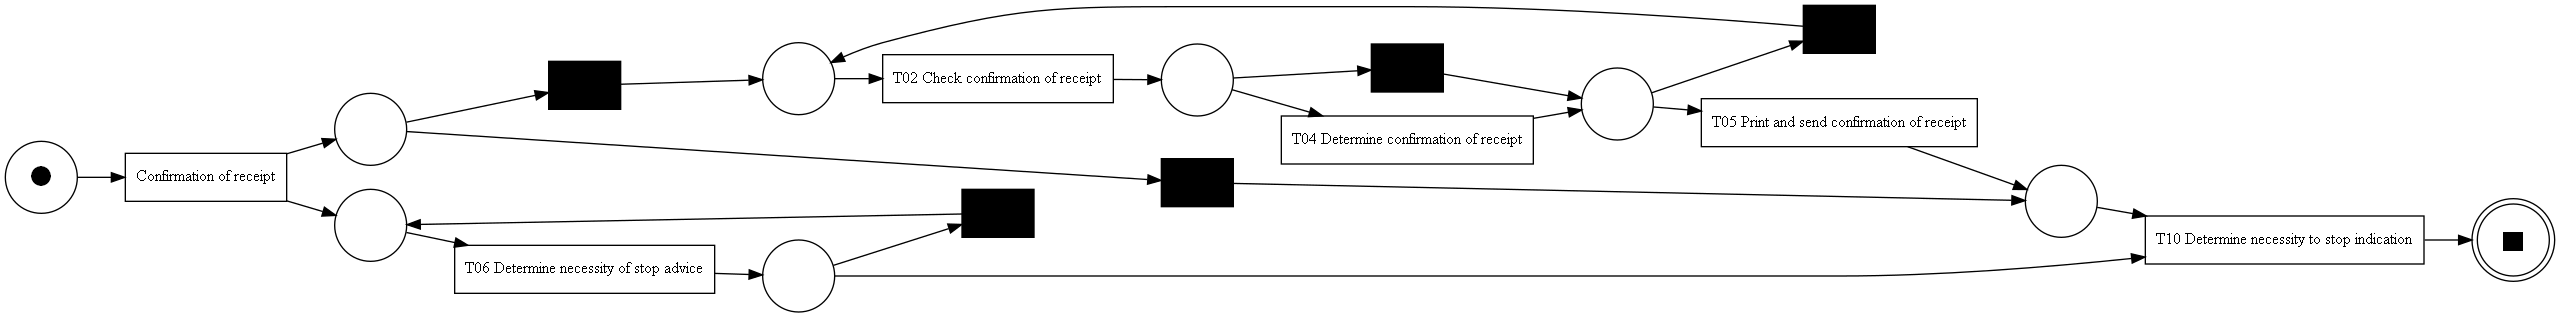

In [67]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz_pn = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz_pn)

We now apply the token-based replay with special settings. 
- With disable_variants set to True we avoid to replay only a case with variant
- With enable_pltr_fitness set to True we tell the algorithm to return localized Conformance Checking application.


In [68]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, 
                  token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, net,
                                                                                              initial_marking,
                                                                                              final_marking,
                                                                                              parameters=parameters_tbr)
                                

replaying log with TBR, completed variants ::   0%|          | 0/1434 [00:00<?, ?it/s]

#### Diagnostics information
#### 1. Throughput analysis
> Throughput analysis (unfit execution)

To perform throughput analysis on the transitions that were executed unfit we use the following:

In [69]:
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics

trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(log, trans_fitness)

for trans in trans_diagnostics:
    print(trans, trans_diagnostics[trans])

(40605983-ea0d-4818-9ab1-1d7163e7ca13, 'T02 Check confirmation of receipt') {'n_fit': 1156, 'n_underfed': 160, 'fit_median_time': 3052.1035, 'underfed_median_time': 258311.8065, 'relative_throughput': 84.63402584479851}
(5c43a6cb-89a8-4a75-b19b-9d94ac751c03, 'T10 Determine necessity to stop indication') {'n_fit': 1032, 'n_underfed': 251, 'fit_median_time': 1382.952, 'underfed_median_time': 94966.921, 'relative_throughput': 68.66971594097265}


> Throughput analysis (activities)

To perform throughput analysis on the process executions containing activities that are not in the model, and then printing results:

In [70]:
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics

act_diagnostics = duration_diagnostics.diagnose_from_notexisting_activities(log, unwanted_activities)
count=0
for act in act_diagnostics:
    print(act, act_diagnostics[act])
    count += 1
    if count == 5:
        break

T07-1 Draft intern advice aspect 1 {'n_containing': 29, 'n_fit': 1282, 'fit_median_time': 1189.2385, 'containing_median_time': 173191.099, 'relative_throughput': 145.63193085323087}
T11 Create document X request unlicensed {'n_containing': 44, 'n_fit': 1282, 'fit_median_time': 1189.2385, 'containing_median_time': 597776.9994999999, 'relative_throughput': 502.6552701581726}
T12 Check document X request unlicensed {'n_containing': 40, 'n_fit': 1282, 'fit_median_time': 1189.2385, 'containing_median_time': 597776.9994999999, 'relative_throughput': 502.6552701581726}
T14 Determine document X request unlicensed {'n_containing': 39, 'n_fit': 1282, 'fit_median_time': 1189.2385, 'containing_median_time': 594627.467, 'relative_throughput': 500.0069094634928}
T15 Print document X request unlicensed {'n_containing': 39, 'n_fit': 1282, 'fit_median_time': 1189.2385, 'containing_median_time': 594627.467, 'relative_throughput': 500.0069094634928}


In [71]:
print(log[0])

{'attributes': {'startdate': datetime.datetime(2011, 10, 11, 13, 42, 22, 688000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'responsible': 'Resource21', 'enddate_planned': datetime.datetime(2011, 12, 6, 13, 41, 31, 788000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'department': 'General', 'group': 'Group 2', 'concept:name': 'case-10011', 'deadline': datetime.datetime(2011, 12, 6, 13, 41, 31, 788000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'channel': 'Internet'}, 'events': [{'org:group': 'Group 1', 'concept:instance': 'task-42933', 'org:resource': 'Resource21', 'concept:name': 'Confirmation of receipt', 'time:timestamp': datetime.datetime(2011, 10, 11, 13, 45, 40, 276000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'lifecycle:transition': 'complete'}, '..', {'org:group': 'Group 4', 'concept:instance': 'task-47958', 'org:resource': 'Resource21', 'concept:name': 'T02 Check confirmation of receipt', 'time:timestamp'

#### 2. Root cause analysis
The output of root cause analysis in the diagnostics context is a decision tree that permits to understand the causes of a deviation.

Here, the decision tree are built on the choice of attributes, org:resource.

> Root Cause Analysis (unfit execution)

To perform rca on transitions that are executed in an unfit way:

In [72]:
string_attributes = ["org:group"]
numeric_attributes = []
parameters = {"string_attributes": string_attributes, "numeric_attributes": numeric_attributes}

In [73]:
from pm4py.algo.conformance.tokenreplay.diagnostics import root_cause_analysis
trans_root_cause = root_cause_analysis.diagnose_from_trans_fitness(log, trans_fitness, parameters=parameters)

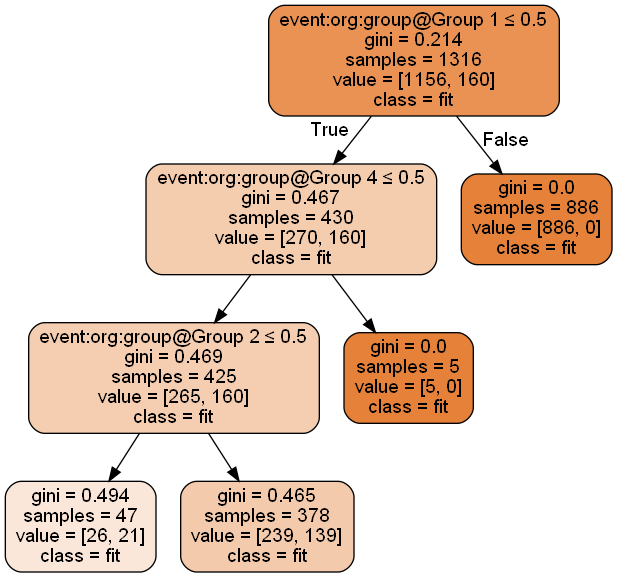

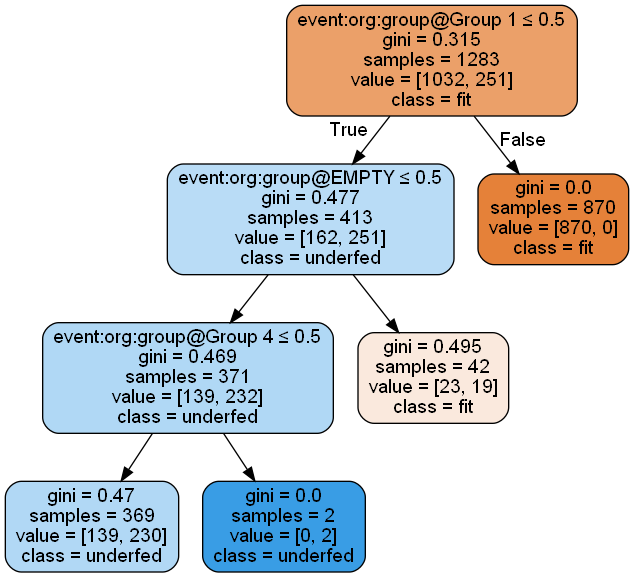

In [74]:
#visualizing the decision trees obtained by root cause analysis
from pm4py.visualization.decisiontree import visualizer as dt_vis
count=0
for trans in trans_root_cause:
    clf = trans_root_cause[trans]["clf"]
    feature_names = trans_root_cause[trans]["feature_names"]
    classes = trans_root_cause[trans]["classes"]
    
    gviz = dt_vis.apply(clf, feature_names, classes)
    dt_vis.view(gviz)
    count+=1
    if count==5:
        break

## 2. Alignments

<hr>
Alignment-based replay aims to find one of the best alignment between the trace and the model. For each trace, the output of an alignment is a list of couples where the first element is an event (of the trace) or » (i.e. no move) and the second element is a transition (of the model) or ». For each couple, the following classification could be provided:

- **Sync move:** the classification of the event corresponds to the transition label; in this case, both the trace and the model advance in the same way during the replay.
- **Move on log:** for couples where the second element is », it corresponds to a replay move in the trace that is not mimicked in the model. This kind of move is unfit and signal a deviation between the trace and the model.
- **Move on model:** for couples where the first element is », it corresponds to a replay move in the model that is not mimicked in the trace. For moves on model, we can have the following distinction:
    - Moves on model involving hidden transitions: in this case, even if it is not a sync move, the move is fit.
    - Moves on model not involving hidden transitions: in this case, the move is unfit and signals a deviation between the trace and the model.

In [75]:
log = xes_importer.apply('C:/Users/AREFA/Documents/DataScienceProjects/PM4PY/running-example.xes')

net, initial_marking, final_marking = inductive_miner.apply(log)

from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking)

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

In [48]:
print(aligned_traces[0])

{'alignment': [('register request', 'register request'), ('>>', None), ('examine casually', 'examine casually'), ('check ticket', 'check ticket'), ('decide', 'decide'), ('reinitiate request', 'reinitiate request'), ('>>', None), ('examine thoroughly', 'examine thoroughly'), ('check ticket', 'check ticket'), ('decide', 'decide'), ('>>', None), ('pay compensation', 'pay compensation')], 'cost': 3, 'visited_states': 13, 'queued_states': 43, 'traversed_arcs': 43, 'lp_solved': 1, 'fitness': 1.0, 'bwc': 140002}


In [55]:

for key in (aligned_traces[0]):
    if key=='alignment':
        print("Alignments of Trace 1:")
        print("--------------------------------------------------------------------")
        for pair in (aligned_traces[0]['alignment']):
            print(pair)
    else:
        print("\n")
        print(key, " : ", aligned_traces[0][key])

Alignments of Trace 1:
--------------------------------------------------------------------
('register request', 'register request')
('>>', None)
('examine casually', 'examine casually')
('check ticket', 'check ticket')
('decide', 'decide')
('reinitiate request', 'reinitiate request')
('>>', None)
('examine thoroughly', 'examine thoroughly')
('check ticket', 'check ticket')
('decide', 'decide')
('>>', None)
('pay compensation', 'pay compensation')


cost  :  3


visited_states  :  13


queued_states  :  43


traversed_arcs  :  43


lp_solved  :  1


fitness  :  1.0


bwc  :  140002


### Output
The output (a list) reports for each trace the corresponding alignment along with its statistics. With each trace, a dictionary containing among the others the following information is associated:

##### alignment: 
contains the alignment (sync moves, moves on log, moves on model)
##### cost: 
contains the cost of the alignment according to the provided cost function
##### fitness: 
is equal to 1 if the trace is perfectly fitting

The formula for fitness of a trace on model N is:
> <img src="https://i.postimg.cc/d10V0Cjb/fitness-trace-alignment.png" width = 200px>
> which is 1 - (cost of optimal alignment / cost of worst case alignment)

The formula for fitness of a log on model N is:
> <img src="https://i.postimg.cc/4NGNKjPv/fitness-log-alignment.png" width = 300px>
> which is 1 - (freq of trace * cost of optimal alignment of trace / freq * cost of worst case alignment of trace)

Thus, fitness gives a measure of how well the model performs on the log.